In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('2008.csv')

In [3]:
df.head()

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2008      1           3          4   2003.0        1955   2211.0   
1  2008      1           3          4    754.0         735   1002.0   
2  2008      1           3          4    628.0         620    804.0   
3  2008      1           3          4    926.0         930   1054.0   
4  2008      1           3          4   1829.0        1755   1959.0   

   CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0        2225            WN        335  ...    4.0      8.0          0   
1        1000            WN       3231  ...    5.0     10.0          0   
2         750            WN        448  ...    3.0     17.0          0   
3        1100            WN       1746  ...    3.0      7.0          0   
4        1925            WN       3920  ...    3.0     10.0          0   

   CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0               NaN         0           NaN          NaN      NaN   
1               NaN         0           NaN          NaN      NaN   
2               NaN         0           NaN          NaN      NaN   
3               NaN         0           NaN          NaN      NaN   
4               NaN         0           2.0          0.0      0.0   

   SecurityDelay  LateAircraftDelay  
0            NaN                NaN  
1            NaN                NaN  
2            NaN                NaN  
3            NaN                NaN  
4            0.0               32.0  

[5 rows x 29 columns]

In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Year               7009728 non-null  int64  
 1   Month              7009728 non-null  int64  
 2   DayofMonth         7009728 non-null  int64  
 3   DayOfWeek          7009728 non-null  int64  
 4   DepTime            6873482 non-null  float64
 5   CRSDepTime         7009728 non-null  int64  
 6   ArrTime            6858079 non-null  float64
 7   CRSArrTime         7009728 non-null  int64  
 8   UniqueCarrier      7009728 non-null  object 
 9   FlightNum          7009728 non-null  int64  
 10  TailNum            6926363 non-null  object 
 11  ActualElapsedTime  6855029 non-null  float64
 12  CRSElapsedTime     7008884 non-null  float64
 13  AirTime            6855029 non-null  float64
 14  ArrDelay           6855029 non-null  float64
 15  DepDelay           6873482 non-n

## Preporcessing

Для симуляции нам нужны только Year, Month, DayOfMonth, CRSDepTime, CRSArrTime, Origin и Dest.  
Время нужно привести к UTC

Получаем информацию о timezone

In [5]:
airport_timezone = pd.read_fwf(
    'https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap',
    names=['code', 'tz'],
    colspecs=[(0, 3), (3, None)]
)

Проверяем есть ли разница между датафреймами с timezone и данными

In [6]:
def find_the_pass(frame):
    print('airports without timezone:')
    airports = pd.Series(df['Origin'].unique())
    codes = frame.code.unique()
    pass_airports = [ap not in codes for ap in airports]
    for airport in airports[pass_airports]:
        print(airport)

find_the_pass(airport_timezone)

airports without timezone:
PFN


Указываем руками недостающий timezone

In [7]:
airport_timezone.loc[len(airport_timezone.index)] = ['PFN', 'America/Chicago']
airport_timezone.index = airport_timezone['code'].values

Теперь преобразуем записи о времени в более human readable формат

In [8]:
df[['CRSDepTime', 'CRSArrTime']].describe()

CRSDepTime    CRSArrTime
count  7.009728e+06  7.009728e+06
mean   1.326086e+03  1.494801e+03
std    4.642509e+02  4.826728e+02
min    0.000000e+00  0.000000e+00
25%    9.250000e+02  1.115000e+03
50%    1.320000e+03  1.517000e+03
75%    1.715000e+03  1.907000e+03
max    2.359000e+03  2.400000e+03

In [9]:
from dateutil import tz
from datetime import datetime, timedelta
import pytz

def to_str_time(int_time):
    str_time = str(int_time).rjust(4, '0')
    return f'{str_time[:2]}:{str_time[2:]}'

def timezone(airport_code):
    return tz.gettz(airport_timezone.loc[airport_code, 'tz'])

@np.vectorize
def to_datetime(year, month, day, time, tz):
    hour, minute = time.split(sep=':')
    return datetime(year=year, month=month, day=day, hour=int(hour), minute=int(minute), tzinfo=timezone(tz)).astimezone(pytz.utc)

def processing(df):
    df.loc[df['CRSArrTime'] >= 2400, 'CRSArrTime'] = 2359
    df.loc[df['CRSDepTime'] >= 2400, 'CRSDepTime'] = 2359

    df['CRSArrTime'] = df['CRSArrTime'].apply(to_str_time)
    df['CRSDepTime'] = df['CRSDepTime'].apply(to_str_time)

    # создаем даты
    df['arr_date'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['CRSArrTime'], df['Dest'])
    df['dep_date'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['CRSDepTime'], df['Origin'])

    proc_df = df[['Origin', 'Dest', 'arr_date', 'dep_date']]
    proc_df = df[['dep_date', 'Origin', 'arr_date', 'Dest']]
    proc_df.columns = ['departure', 'origin', 'arrival', 'destination']

    # проверка ночных рейсов
    proc_df.loc[proc_df['departure'] > proc_df['arrival'], 'arrival'] += timedelta(hours=24)
    proc_df.sort_values('departure', inplace=True)

    return proc_df

In [10]:
proc_df = processing(df)
proc_df

departure origin                   arrival destination
546722  2008-01-01 05:35:00+00:00    MCO 2008-01-01 08:20:00+00:00         SJU
573205  2008-01-01 07:00:00+00:00    SJU 2008-01-01 11:07:00+00:00         EWR
588019  2008-01-01 07:25:00+00:00    PHX 2008-01-01 12:09:00+00:00         JFK
546834  2008-01-01 07:25:00+00:00    SJU 2008-01-01 11:23:00+00:00         JFK
588977  2008-01-01 07:45:00+00:00    PHX 2008-01-01 11:12:00+00:00         ATL
...                           ...    ...                       ...         ...
6729687 2009-01-01 09:40:00+00:00    OGG 2009-01-01 15:25:00+00:00         PHX
6729504 2009-01-01 09:45:00+00:00    KOA 2009-01-01 15:34:00+00:00         PHX
6853534 2009-01-01 09:50:00+00:00    HNL 2009-01-01 15:19:00+00:00         PDX
6729467 2009-01-01 09:55:00+00:00    HNL 2009-01-01 16:00:00+00:00         PHX
6663085 2009-01-01 09:59:00+00:00    HNL 2009-01-01 15:05:00+00:00         SFO

[7009728 rows x 4 columns]

In [11]:
proc_df.head()

departure origin                   arrival destination
546722 2008-01-01 05:35:00+00:00    MCO 2008-01-01 08:20:00+00:00         SJU
573205 2008-01-01 07:00:00+00:00    SJU 2008-01-01 11:07:00+00:00         EWR
588019 2008-01-01 07:25:00+00:00    PHX 2008-01-01 12:09:00+00:00         JFK
546834 2008-01-01 07:25:00+00:00    SJU 2008-01-01 11:23:00+00:00         JFK
588977 2008-01-01 07:45:00+00:00    PHX 2008-01-01 11:12:00+00:00         ATL

## Симуляция

In [12]:
def time(init_airport):
    airport_df = proc_df[proc_df['origin'] == init_airport]
    return airport_df['departure'].iloc[0]

def is_chance_be_infected(p):
    return np.random.uniform() < p

def is_can_be_infected(row, p, infected):
    return (row.origin in infected) and (row.destination not in infected) and is_chance_be_infected(p)

def print_infected_percent(infected_results):
    infected_count = len(infected_results)
    all_count = len(proc_df['destination'].unique())
    print('Infected: ', infected_count, '/', all_count,  'Percent: ', infected_count / all_count * 100, '%')

def simulation(init_airport, p, verbose=False):
    init_time = time(init_airport)
    infected = [init_airport]
    infected_airports = {init_time : init_airport}
    can_be_infected_by_time = proc_df[proc_df['departure'] > init_time]

    for row in can_be_infected_by_time.itertuples():
        if (is_can_be_infected(row, p, infected)):
            infected.append(row.destination)
            infected_airports[row.arrival] = row.destination
            if verbose:
                print(len(infected), ' infected ', row.destination, ' ', row.arrival)
    
    print_infected_percent(infected)
    return infected_airports

result = simulation('ABE', 0.5, verbose=True)

2  infected  ORD   2008-01-01 14:34:00+00:00
3  infected  FLL   2008-01-01 15:35:00+00:00
4  infected  DCA   2008-01-01 14:20:00+00:00
5  infected  CVG   2008-01-01 13:50:00+00:00
6  infected  PHL   2008-01-01 15:19:00+00:00
7  infected  RST   2008-01-01 13:50:00+00:00
8  infected  DFW   2008-01-01 15:12:00+00:00
9  infected  IAH   2008-01-01 15:30:00+00:00
10  infected  RSW   2008-01-01 15:15:00+00:00
11  infected  PBI   2008-01-01 15:20:00+00:00
12  infected  LAX   2008-01-01 16:00:00+00:00
13  infected  MEM   2008-01-01 14:30:00+00:00
14  infected  MSY   2008-01-01 16:09:00+00:00
15  infected  CLE   2008-01-01 14:00:00+00:00
16  infected  LAS   2008-01-01 18:25:00+00:00
17  infected  MIA   2008-01-01 15:58:00+00:00
18  infected  SDF   2008-01-01 14:05:00+00:00
19  infected  SFO   2008-01-01 17:15:00+00:00
20  infected  STL   2008-01-01 15:10:00+00:00
21  infected  LGA   2008-01-01 15:45:00+00:00
22  infected  BNA   2008-01-01 14:40:00+00:00
23  infected  DTW   2008-01-01 14:33:00+00

In [13]:
df_simulation_run_result_columns = ['p', 'simulation num', 'airport', 'infected']

def simultaion_run(init_airport, probs, num_simulations, verbose=False):
    df_simultaion_run_result = pd.DataFrame(columns=df_simulation_run_result_columns)
    for p in probs:
        print('simulations for probability = ', p)
        for num in range(num_simulations):
            np.random.seed(num)
            result = simulation(init_airport, p, verbose)
            df_simulation_result = pd.DataFrame.from_dict(result, orient='index').reset_index()
            df_simulation_result.columns = ['infected', 'airport']
            df_simulation_result['p'] = p
            df_simulation_result['simulation num'] = num
            df_simultaion_run_result = pd.concat([df_simultaion_run_result, df_simulation_result])
        print('\n')
    return df_simultaion_run_result
            

In [14]:
probs = [0.01, 0.05, 0.1, 0.5, 1.]
num_simulations = 10

df_result = simultaion_run('ABE', probs, num_simulations, verbose=False)
df_result

simulations for probability =  0.01
Infected:  299 / 304 Percent:  98.35526315789474 %
Infected:  294 / 304 Percent:  96.71052631578947 %
Infected:  293 / 304 Percent:  96.38157894736842 %
Infected:  295 / 304 Percent:  97.03947368421053 %
Infected:  296 / 304 Percent:  97.36842105263158 %
Infected:  297 / 304 Percent:  97.69736842105263 %
Infected:  294 / 304 Percent:  96.71052631578947 %
Infected:  297 / 304 Percent:  97.69736842105263 %
Infected:  295 / 304 Percent:  97.03947368421053 %
Infected:  294 / 304 Percent:  96.71052631578947 %


simulations for probability =  0.05
Infected:  300 / 304 Percent:  98.68421052631578 %
Infected:  300 / 304 Percent:  98.68421052631578 %
Infected:  300 / 304 Percent:  98.68421052631578 %
Infected:  300 / 304 Percent:  98.68421052631578 %
Infected:  300 / 304 Percent:  98.68421052631578 %
Infected:  301 / 304 Percent:  99.01315789473685 %
Infected:  302 / 304 Percent:  99.3421052631579 %
Infected:  299 / 304 Percent:  98.35526315789474 %
Infected:

p simulation num airport                  infected
0    0.01              0     ABE 2008-01-01 11:05:00+00:00
1    0.01              0     ATL 2008-01-08 14:05:00+00:00
2    0.01              0     CVG 2008-01-08 19:19:00+00:00
3    0.01              0     EWR 2008-01-08 20:16:00+00:00
4    0.01              0     PWM 2008-01-08 22:11:00+00:00
..    ...            ...     ...                       ...
216  1.00              9     LMT 2008-07-07 19:36:00+00:00
217  1.00              9     OTH 2008-07-07 19:52:00+00:00
218  1.00              9     ITH 2008-08-20 02:45:00+00:00
219  1.00              9     HTS 2008-10-01 15:17:00+00:00
220  1.00              9     PIR 2008-11-05 18:55:00+00:00

[12892 rows x 4 columns]

In [15]:
def time_of_infection(df):
    size = len(df['airport'].unique())
    min_time = df['infected'].min()
    max_time = df['infected'].max()
    result_dict = dict()
    time = min_time

    while time < max_time:
        infected_percent = df[df['infected'] <= time].groupby(['p', 'simulation num']).size() / size * 100
        infected_percent = infected_percent.reset_index().groupby('p')[0].mean()
        result_dict[time] = infected_percent
        time += timedelta(hours=12)
    
    return result_dict

time_result = time_of_infection(df_result)

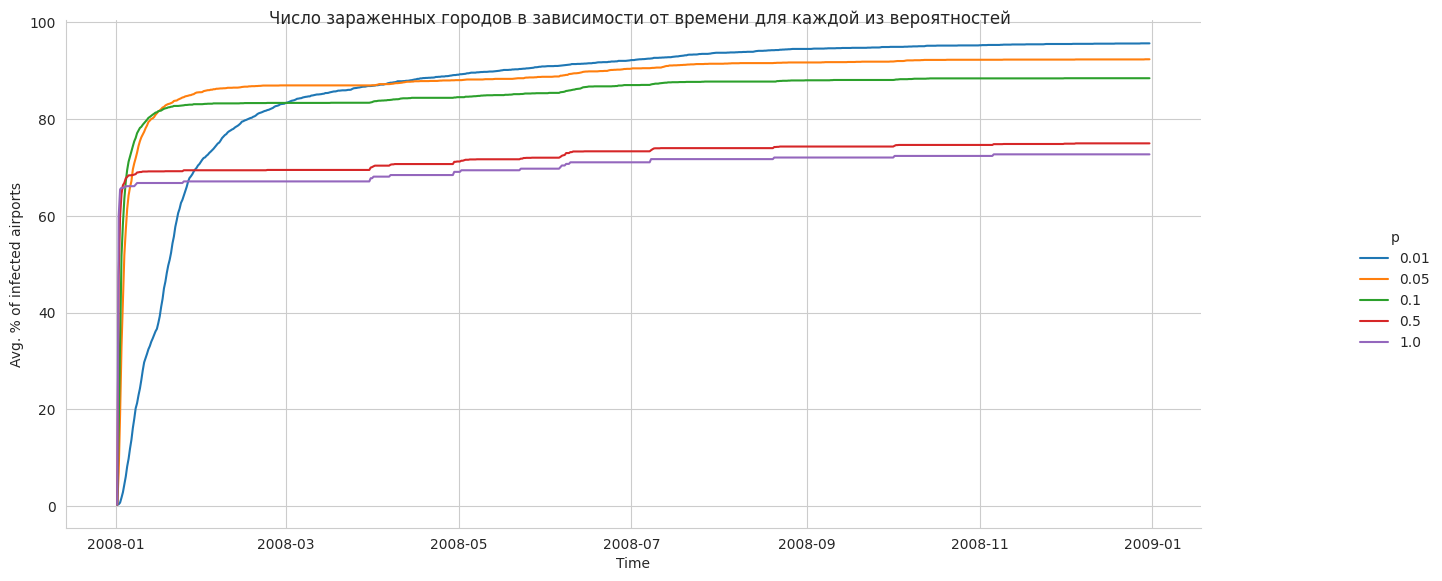

In [19]:
def infection_rate_chart(time_result):
    data = pd.DataFrame.from_dict(time_result, orient='index')
    data = data.reset_index().melt(id_vars='index', var_name='p')
    data['p'] = data.p.astype('category')
    sns.set_style('whitegrid')
    plot = sns.relplot(data=data, kind='line', x='index', y='value', hue='p')
    plot.figure.set_figwidth(16)
    plot.figure.set_figheight(6)
    plot.figure.suptitle('Число зараженных городов в зависимости от времени для каждой из вероятностей')
    plot.ax.set_xlabel('Время')
    plot.ax.set_ylabel('Средний % зараженных аэропортов')
    plt.show()

infection_rate_chart(time_result)

## Построение графа

In [22]:
@np.vectorize
def grouping_of_flights(origin, destination):
    if origin < destination:
        result = f'{origin} {destination}'
    else:
        result = f'{destination} {origin}'
    return result

In [24]:
proc_df['edge'] = grouping_of_flights(proc_df['origin'], proc_df['destination'])
edgelist = proc_df.groupby('edge').size() / proc_df.shape[0]
edgelist = edgelist.reset_index()
edgelist[['node0', 'node1']] = edgelist['edge'].str.split(' ', expand=True)
edgelist = edgelist[['node0', 'node1', 0]]
edgelist.columns = ['node0', 'node1', 'weight']
edgelist.to_csv('edgelist.csv', header=False, index=False, sep=' ')
edgelist

node0 node1        weight
0      ABE   ATL  2.432334e-04
1      ABE   BHM  1.426589e-07
2      ABE   CLE  2.296808e-04
3      ABE   CLT  1.326728e-04
4      ABE   CVG  7.061615e-05
...    ...   ...           ...
2829   STL   TUL  2.552168e-04
2830   SUN   TWF  4.279767e-07
2831   SWF   TPA  6.704968e-05
2832   TLH   TPA  8.588065e-05
2833   TUL   XNA  1.426589e-07

[2834 rows x 3 columns]

In [27]:
ag = nx.read_weighted_edgelist('edgelist.csv', nodetype=str)
print(ag.number_of_nodes(), 'nodes and ', ag.number_of_edges(), 'edges in the graph')

305 nodes and  2834 edges in the graph


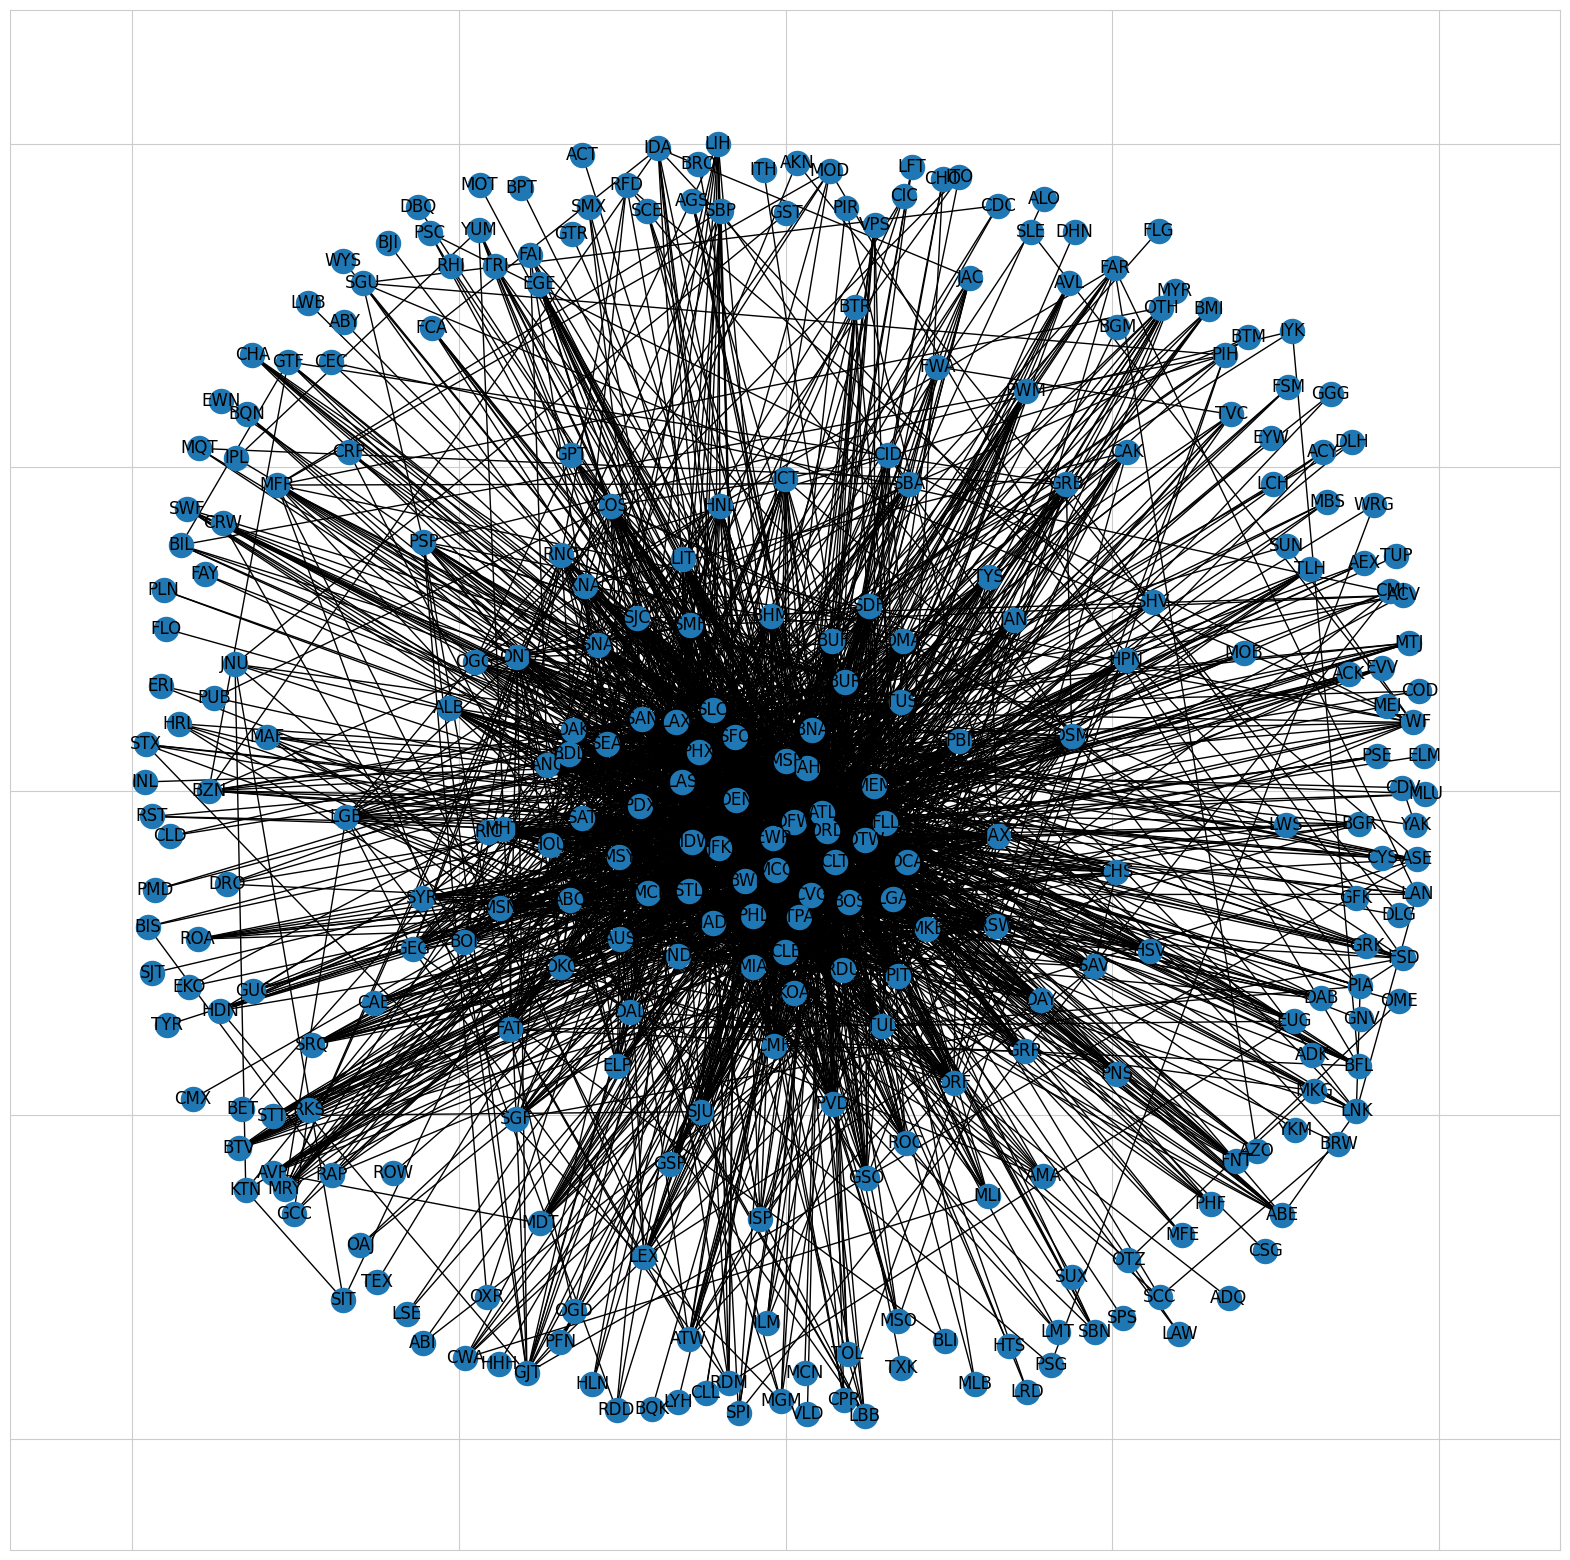

In [30]:
fig = plt.figure(1, figsize=(20, 20))
nx.draw_networkx(ag)

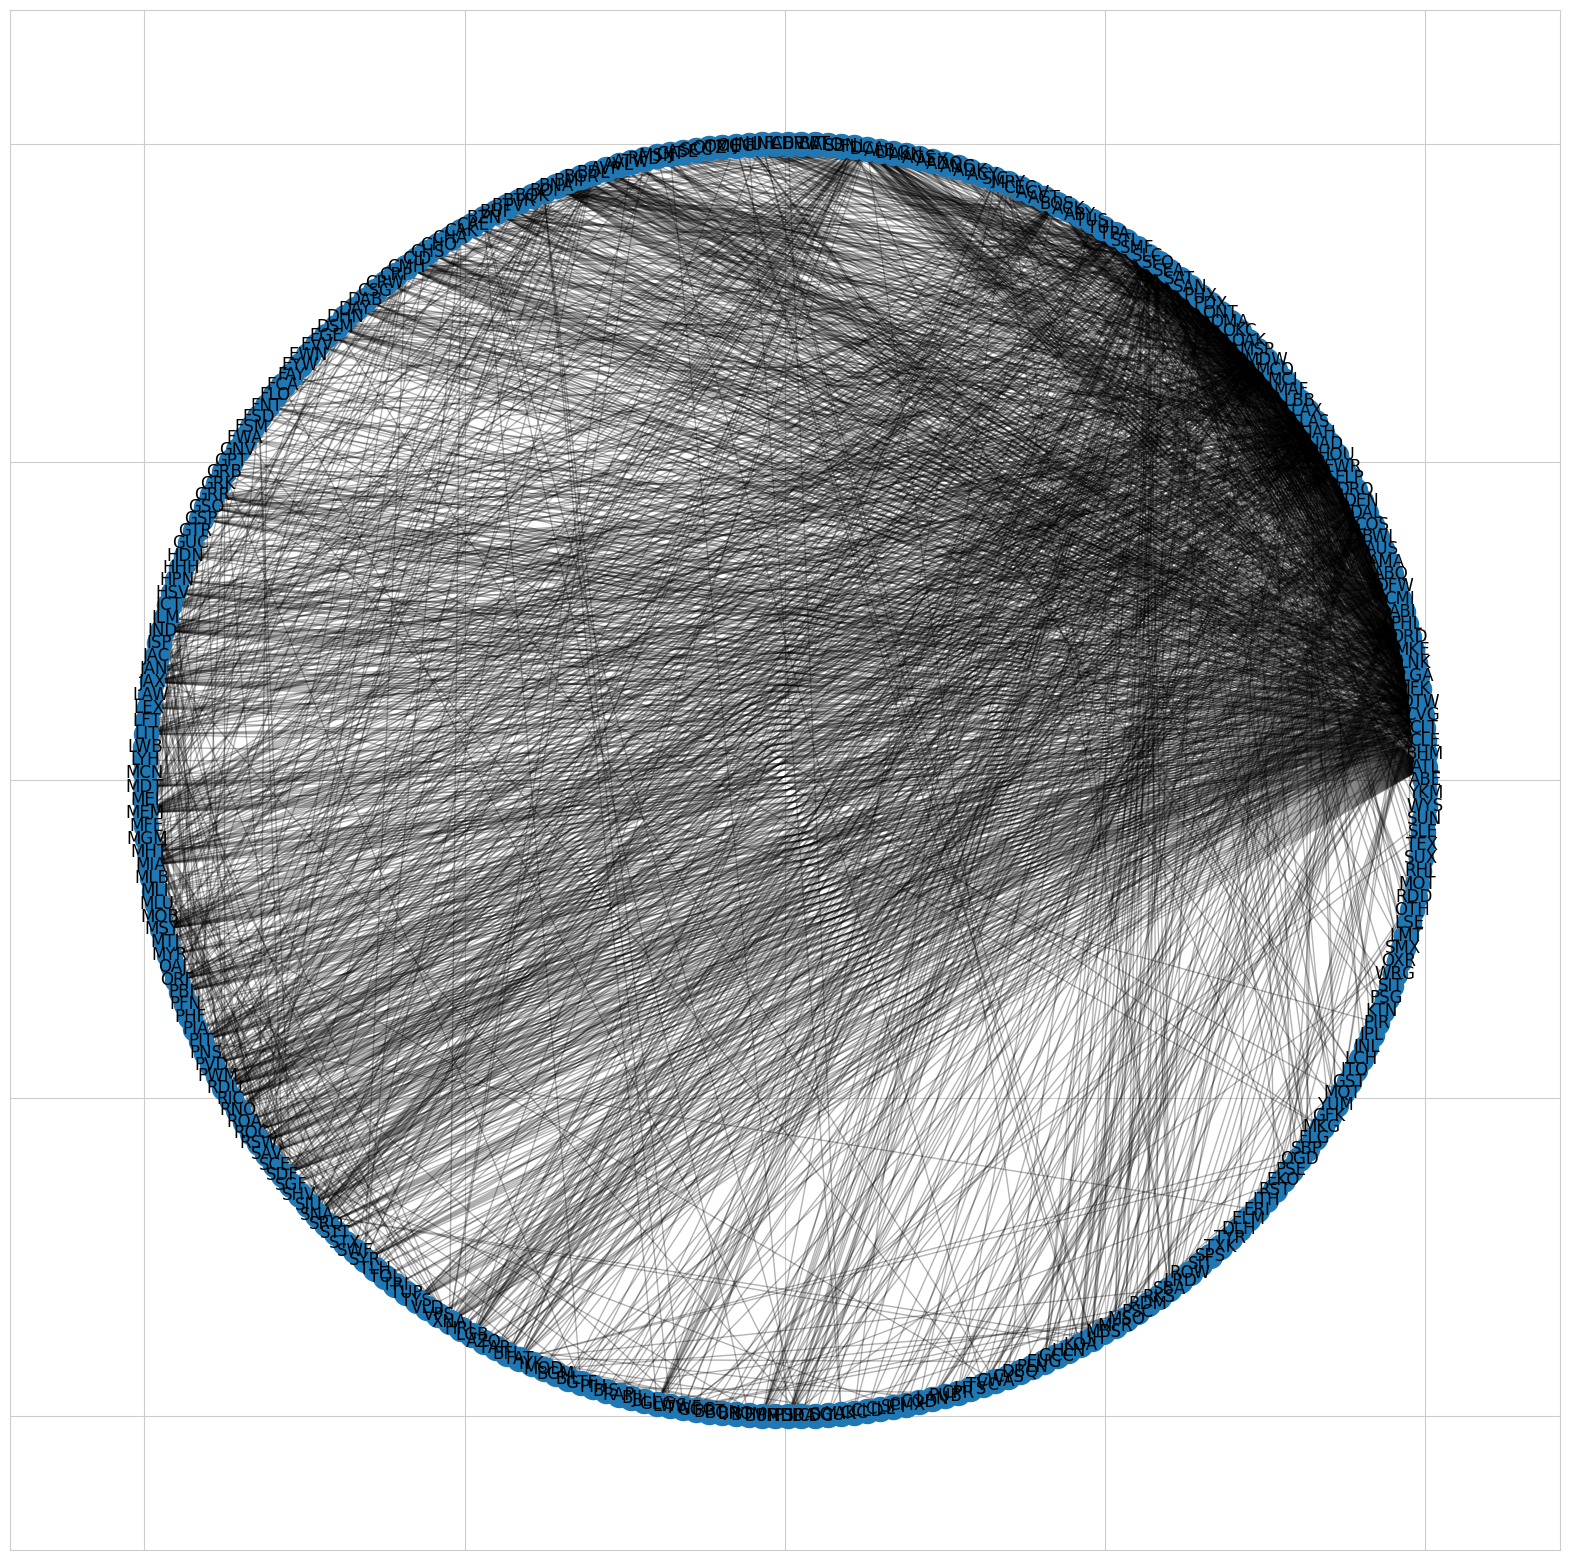

In [31]:
fig = plt.figure(1, figsize=(20, 20))
pos = nx.circular_layout(ag)
nx.draw_networkx_nodes(ag, pos=pos)
nx.draw_networkx_edges(ag, pos=pos, alpha=0.3)
nx.draw_networkx_labels(ag, pos=pos)
plt.show()

## 50 Симуляций для расчета медианного времени заражения для каждого города

In [32]:
probs = [0.5]
num_simulations = 50

df_50_simulations_result = simultaion_run('ABE', probs, num_simulations, verbose=False)
df_50_simulations_result

simulations for probability =  0.5
Infected:  304 / 304 Percent:  100.0 %
Infected:  303 / 304 Percent:  99.67105263157895 %
Infected:  303 / 304 Percent:  99.67105263157895 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  303 / 304 Percent:  99.67105263157895 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  302 / 304 Percent:  99.3421052631579 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  303 / 304 Percent:  99.67105263157895 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  303 / 304 Percent:  99.67105263157895 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  303 / 304 Percent:  99.67105263157895 %
Infected:  304 / 304 Percent:  100.0 %
Infected:  303 / 304 Percent:  99.67105263157895 %
Infected:  3

p simulation num airport                  infected
0    0.5              0     ABE 2008-01-01 11:05:00+00:00
1    0.5              0     BTR 2008-01-01 19:47:00+00:00
2    0.5              0     GRB 2008-01-01 22:05:00+00:00
3    0.5              0     BFL 2008-01-01 21:57:00+00:00
4    0.5              0     PHX 2008-01-01 19:03:00+00:00
..   ...            ...     ...                       ...
234  0.5             49     OTH 2008-07-07 19:52:00+00:00
235  0.5             49     LMT 2008-07-08 04:54:00+00:00
236  0.5             49     ITH 2008-08-20 02:45:00+00:00
237  0.5             49     HTS 2008-10-01 15:17:00+00:00
238  0.5             49     PIR 2008-11-05 18:55:00+00:00

[11451 rows x 4 columns]

### Считаем медианное время

In [33]:
df_50_simulations_result = df_50_simulations_result.reset_index(drop=True)
start_time = df_50_simulations_result.loc[0, 'infected']
df_50_simulations_result['dt'] = df_50_simulations_result['infected'] - start_time
median_time = df_50_simulations_result.groupby('airport')['dt'].median().astype('timedelta64[s]')
median_time

airport
ABE     0 days 00:00:00
ABI     0 days 08:45:00
ABQ     0 days 06:26:00
ABY     1 days 04:27:00
ACK   142 days 05:18:00
             ...       
WYS   158 days 06:10:30
XNA     0 days 06:08:30
YAK     1 days 09:29:00
YKM     0 days 18:50:00
YUM     0 days 06:38:00
Name: dt, Length: 304, dtype: timedelta64[s]

### Считаем коэф. кластеризации, степень и центральность

In [51]:
clustering = nx.clustering(ag, weight='weight')
degree = dict(ag.degree(weight='weight'))
centrality = nx.betweenness_centrality(ag, weight='weight')

node_metrics = pd.DataFrame.from_dict(clustering, orient='index', columns=['clustering']).join([
               pd.DataFrame.from_dict(degree, orient='index', columns=['degree']),
               pd.DataFrame.from_dict(centrality, orient='index', columns=['centrality'])
])
node_metrics

clustering    degree  centrality
ABE    0.025966  0.001370    0.001032
ATL    0.022777  0.118269    0.127454
BHM    0.042371  0.006756    0.020993
CLE    0.033988  0.018772    0.000000
CLT    0.042964  0.035961    0.044871
..          ...       ...         ...
TEX    0.000000  0.000055    0.000000
SLE    0.007017  0.000138    0.000000
SUN    0.014566  0.000824    0.000000
WYS    0.000000  0.000075    0.000000
YKM    0.000000  0.000097    0.000000

[305 rows x 3 columns]

In [52]:
time_and_graph_metrics = node_metrics.join(median_time)
time_and_graph_metrics['hours'] = time_and_graph_metrics['dt'].dt.total_seconds() / 60 / 60
time_and_graph_metrics

clustering    degree  centrality                dt        hours
ABE    0.025966  0.001370    0.001032   0 days 00:00:00     0.000000
ATL    0.022777  0.118269    0.127454   0 days 04:43:00     4.716667
BHM    0.042371  0.006756    0.020993   0 days 04:25:00     4.416667
CLE    0.033988  0.018772    0.000000   0 days 03:36:00     3.600000
CLT    0.042964  0.035961    0.044871   0 days 04:17:00     4.283333
..          ...       ...         ...               ...          ...
TEX    0.000000  0.000055    0.000000   0 days 08:41:00     8.683333
SLE    0.007017  0.000138    0.000000   0 days 18:45:00    18.750000
SUN    0.014566  0.000824    0.000000   0 days 06:55:00     6.916667
WYS    0.000000  0.000075    0.000000 158 days 06:10:30  3798.175000
YKM    0.000000  0.000097    0.000000   0 days 18:50:00    18.833333

[305 rows x 5 columns]

### Scatter plot и коэффициент Спирмана

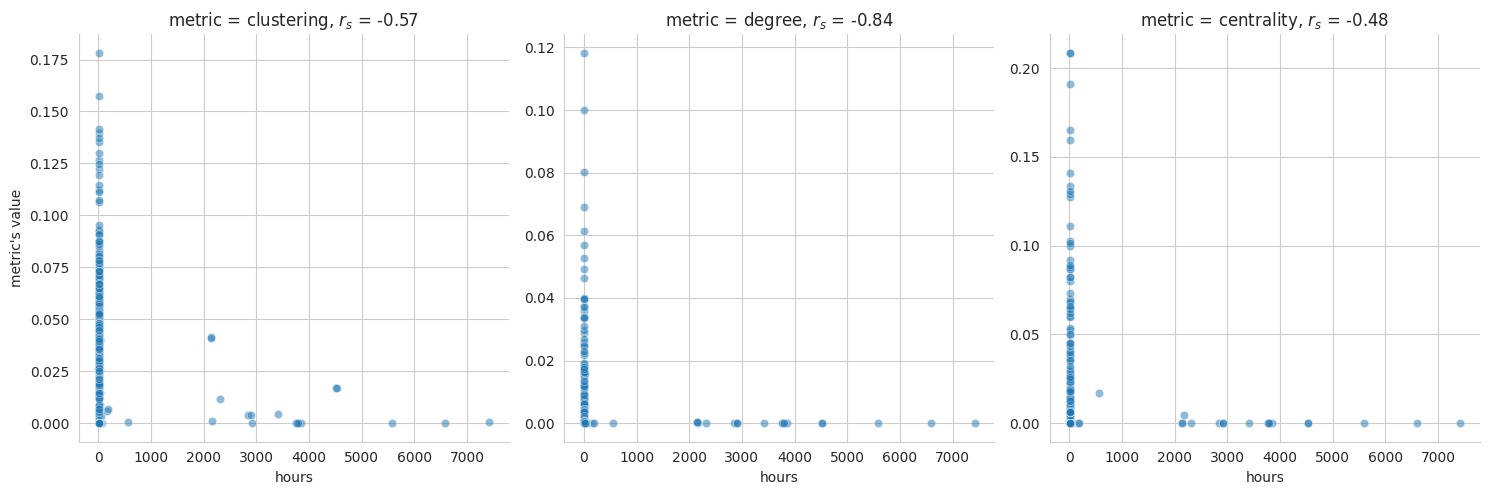

In [53]:

scorr = time_and_graph_metrics.drop('dt', axis=1).corr('spearman').loc['hours']
viz = time_and_graph_metrics.drop('dt', axis=1).reset_index().melt(id_vars=['index', 'hours'], var_name='metric')

sns.set_style('whitegrid')
sp = sns.relplot(data=viz, x='hours', y='value', col='metric', facet_kws={'sharey': False, 'sharex': True}, alpha=0.5)

sp.set_ylabels("metric's value")
axes = sp.fig.axes
for ax in axes:
    current_title = ax.get_title()
    metric_name = current_title.split(' ')[2]
    title = f'{current_title}, $r_{{s}}$ = {round(scorr[metric_name], 2)}'
    ax.set_title(title)
plt.show()

### Вывод

Коэффициент корреляции Спирмана показал сильную обратную связь со степенью (nx.degree).  
Таким образом, можно предсказать, что аэропорт, имеющий набольшее число связей и  
наибольшее число перелетов через него, наиболее подвережен заражению в первые часы